## Python Setup

### Python Version 3.11.3

### Module Imports
- Matplotlib for plotting
- Numpy for all of the analysis
- sklearn to load the data set, compute the confusion matrix, and split the data into training and test sets.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Data Visualization
Data is 2 groups:
- `X`: 1797 64 pixel vectors representing hand written numbers between 0 and 9.  Pixel values between 0 and 16.
- `Y`: 1797 numbers between 0 and 9 representing the true values of X.

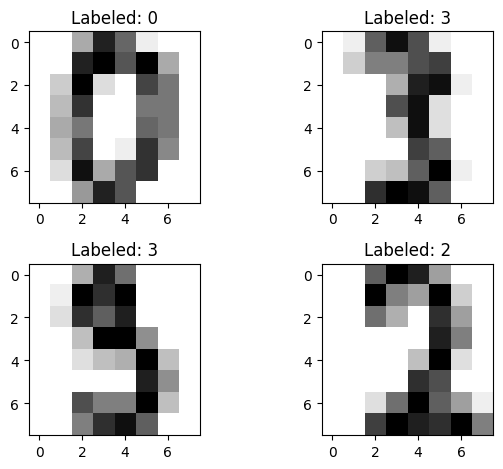

In [2]:
digits_data = load_digits()
X = digits_data["data"].astype(np.int8)
Y = digits_data["target"]

fig, ax = plt.subplots(ncols=2, nrows=2)

ax[0][0].imshow(X[0].reshape(8, 8), cmap="binary")
ax[0][0].set_title(f"Labeled: {Y[0]}")
ax[0][1].imshow(X[59].reshape(8, 8), cmap="binary")
ax[0][1].set_title(f"Labeled: {Y[59]}")
ax[1][0].imshow(X[449].reshape(8, 8), cmap="binary")
ax[1][0].set_title(f"Labeled: {Y[449]}")
ax[1][1].imshow(X[1338].reshape(8, 8), cmap="binary")
ax[1][1].set_title(f"Labeled: {Y[1338]}")
fig.tight_layout()

## Hyperdimensional Vectors
### Vector Definition
The lambda function below generates a set of `x` vectors with 10000 dimensions, value of 1 or -1 randomly assigned.

In [3]:
hdv = lambda x: np.random.choice([-1, 1], (x, 10000)).astype(np.int8)

### Vector Operations
- `bundle`: Sums a collection of vectors along each dimension and returns the sign of each dimension. Used to aggregate vectors of the same type.
- `bind`: Multiplies a set of vectors along each dimension. Used to combine vectors representing data of different types.
- `shift`: Shifts a group of vectors by k dimensions (e.g., shift([1, -1, 1], k=1) -> [1, 1, -1]).
- `cos_sim`: Computes the cosine similarity of two vectors.  Used to compare how alike two vectors are.  Unrelated vectors are very likely to be orthogonal to one another due to the number of dimensions, and consequently will return a value of 0.

#### Reversability 
Each of these operations are reversible.  So the original components can always be recovered.  For example:
- bundle(A, B) = C; bundle(A, C) = B
- bind(A, B) = C; bind(B, C) = A
- shift(shift(A, k=1), k=-1) = A

#### Vector Likeness
Despite the fact that vectors are randomly assigned, any two vectors still share a large number of values.  Consquently, aggregating or binding vectors tends to highlight related features.

In [4]:
def bundle(vecs: NDArray[int]) -> NDArray[int]:
    return np.sign(vecs.sum(axis=0))

def bind(vecs: NDArray[int]) -> NDArray[int]:
    return np.sign(vecs.prod(axis=0))

def shift(vecs: NDArray[int], k: int=1) -> NDArray[int]:
    return np.roll(vecs, axis=-1, shift=k)

def cos_sim(vec1: NDArray[int], vec2: NDArray[int]) -> float:
    return vec1.dot(vec2.T) / (np.linalg.norm(vec1, axis=-1) * np.linalg.norm(vec2, axis=-1))

## Data Representation
### Base data representation
- `numbers`: Just a 10 x 10000 matrix.  For example, the number 2 is represented by `numbers[2, :]`.
- `pixels`: Each unique pixel value similarly represented by a 17 x 10000 matrix.

In [5]:
numbers = hdv(10)
pixels = hdv(17)

### Image Representation
Each image is just a bundle of the unique pixel vectors, but order of the pixels matter too, so we must also include a shift for each subsequent pixel. Ultimately, each image will be represented by a single vector of 10000 dimensions.

$v_{image} = \Sigma_i shift(v_{pixel}, k=i)$

In [6]:
def encode_images(images: NDArray[int], pixels: NDArray[int]=pixels) -> NDArray[int]:
    return np.array([bundle(np.array([shift(pixels[p], k=i) for i, p in enumerate(im)])) for im in images])

### Model Creation
Despite the random assignment of the base data, each image is created in a systematic way.  Consquently, vectors representing images of 0's are similar.  So by bundling all of the image vectors with the same label, we can produce a single vector that shares like features from the original image vectors. By binding that aggregate vector by its label we compute its model.  We end up with a matrix of 10 x 10000 as our model.

$M_i = (\Sigma_i vec_{im}) * vec_{i}$

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2)
models = np.array([bind(np.vstack((bundle(encode_images(train_X[train_Y==i, :])), numbers[i, :]))) 
                   for i in range(numbers.shape[0])])

### Decoding Numbers from Images
As mentioned previously, the bind operation is reversible.  So to compute a prediction for the label we just bind an image to each model, and choose the output with the largest cosine similarity.  This works because the image vector is similar to the aggregate vector for the same number, and binding it to the right model produces a vector that is necessarily close to the associated label vector.

$vec_{im} * M_i = vec_i$

In [8]:
def decode_numbers(vecs: NDArray[int], numbers: NDArray[int]=numbers, models: NDArray[int]=models) -> NDArray[float]:
    return np.array([np.argmax(cos_sim(np.sign(models * vec), numbers).diagonal()) for vec in vecs])

In [9]:
train_predictions = decode_numbers(encode_images(train_X))
train_class_matrix = confusion_matrix(train_Y, train_predictions)

In [10]:
test_predictions = decode_numbers(encode_images(test_X))
test_class_matrix = confusion_matrix(test_Y, test_predictions)

## Model Accuracy
### Confusion Matrix of the Training Dataset

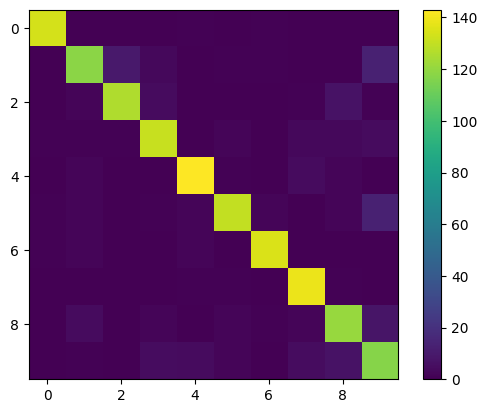

In [15]:
plt.imshow(train_class_matrix)
plt.colorbar()

### Confusion Matrix of the Test Data Set

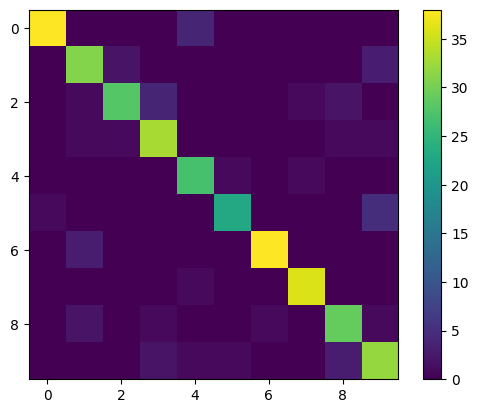

In [16]:
plt.imshow(test_class_matrix)
plt.colorbar()

### Model Accuracy on the Test Dataset
Model accuracy varies but typically returns a value between 90% - 95%. The methodology shown here deterministic, and consequently reproducible.  However, the training and test datasets are random, so the final results vary as well.

In [13]:
acc = 100 * test_class_matrix.diagonal().sum() / test_class_matrix.sum()

print(f"Accuracy: {acc}%")

Accuracy: 87.5%
